In [1]:
import os, sys, pdb
from pathlib import Path
import pandas as pd
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import time
import copy
import gc
%matplotlib inline
%load_ext autoreload
%autoreload 1
DATA_DIR = Path('../input')
MODEL_DIR = Path('../model')
OUT_DIR = Path('../output')
import warnings
warnings.filterwarnings('ignore')

In [2]:
# DATA_DIR = Path(__file__()).resolve().parent[1] / 'input'
# MODEL_DIR = Path(__file__()).resolve().parent[1] / 'model'
# OUT_DIR = Path(__file__()).resolve().parent[1] / 'output'

In [3]:
ls ../input

cinc/                                  test_manifest.csv_01
cinc_manifest.csv                      test_manifest_01.csv
cinc_manifest.csv_test_path_fold.csv   test_manifest_02.csv
cinc_manifest.csv_train_path_fold.csv  train_manifest.csv
cinc_manifest.csv_val_path_fold.csv    train_manifest_01.csv
db1-5/                                 train_manifest_02.csv
db15_devel_manifest.csv                val_manifest.csv
db15_test_manifest.csv                 val_manifest.csv_01
db15_train_manifest.csv                val_manifest_01.csv
devel_manifest.csv                     val_manifest_02.csv
lab/                                   wav/
processed/                             wav_original/
test_manifest.csv


In [4]:
ls ../input/lab/

labels_test.arff  labels_test.txt  labels_train_dev.tsv


In [5]:
ls ../input/wav/

devel_0001.wav  devel_0170.wav  test_0159.wav   train_0165.wav  train_0334.wav
devel_0002.wav  devel_0171.wav  test_0160.wav   train_0166.wav  train_0335.wav
devel_0003.wav  devel_0172.wav  test_0161.wav   train_0167.wav  train_0336.wav
devel_0004.wav  devel_0173.wav  test_0162.wav   train_0168.wav  train_0337.wav
devel_0005.wav  devel_0174.wav  test_0163.wav   train_0169.wav  train_0338.wav
devel_0006.wav  devel_0175.wav  train_0001.wav  train_0170.wav  train_0339.wav
devel_0007.wav  devel_0176.wav  train_0002.wav  train_0171.wav  train_0340.wav
devel_0008.wav  devel_0177.wav  train_0003.wav  train_0172.wav  train_0341.wav
devel_0009.wav  devel_0178.wav  train_0004.wav  train_0173.wav  train_0342.wav
devel_0010.wav  devel_0179.wav  train_0005.wav  train_0174.wav  train_0343.wav
devel_0011.wav  devel_0180.wav  train_0006.wav  train_0175.wav  train_0344.wav
devel_0012.wav  test_0001.wav   train_0007.wav  train_0176.wav  train_0345.wav
devel_0013.wav  test_0002.wav   train_0008.wav  trai

In [6]:
train_dev_label = pd.read_csv(DATA_DIR / 'lab' / 'labels_train_dev.tsv', sep='\t')
train_dev_label.head()

,file_name,label
0,train_0001.wav,2
1,train_0002.wav,0
2,train_0003.wav,1
3,train_0004.wav,2
4,train_0005.wav,2


In [7]:
dic = {}
for phase in ['train', 'devel', 'test']:
    dic[phase] = [str(p.resolve()) for p in (DATA_DIR / 'wav').iterdir() if phase in p.name]
    dic[phase].sort()

In [8]:
train = pd.read_csv(DATA_DIR / 'db15_train_manifest.csv', header=None)


In [9]:
train.head()

,0,1
0,/home/tomoya/workspace/research/heart-sound-ma...,2
1,/home/tomoya/workspace/research/heart-sound-ma...,2
2,/home/tomoya/workspace/research/heart-sound-ma...,2
3,/home/tomoya/workspace/research/heart-sound-ma...,2
4,/home/tomoya/workspace/research/heart-sound-ma...,2


In [10]:
path = train.iloc[0, 0]
path

'/home/tomoya/workspace/research/heart-sound-machine/input/db1-5/wav/train_0001_1.wav'

In [11]:
from librosa.core import load

In [12]:
wave, sr = load(path, sr=4000)
wave

array([-0.02627563, -0.02386475, -0.01989746, ..., -0.01312256,
       -0.01193237, -0.01351929], dtype=float32)

In [13]:
wave.shape

(40000,)

In [14]:
from ml.src.signal_processor import cwt, to_spect, logmel

In [15]:
_ = cwt(wave.reshape((1, -1)))

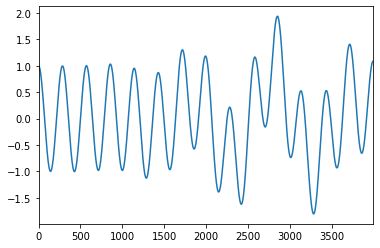

In [84]:
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns
t = np.linspace(-1, 1, 4000, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
pd.Series(sig).plot()

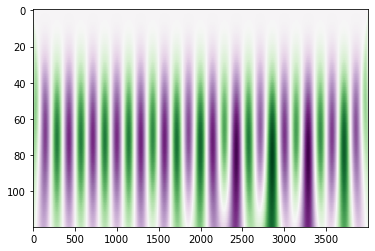

In [85]:
widths = np.arange(1, 121)
cwtmatr = signal.cwt(sig, signal.ricker, widths=widths)
plt.imshow(cwtmatr, cmap='PRGn', aspect='auto')
plt.show()

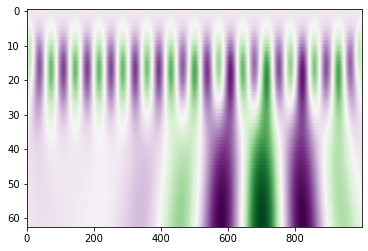

In [88]:
widths = np.arange(1, 64)
cwtmatr = signal.cwt(librosa.core.resample(sig, 2000, 500), signal.ricker, widths=widths)
plt.imshow(cwtmatr, cmap='PRGn', aspect='auto')
plt.show()

In [54]:
pd.DataFrame(cwtmatr.ravel()).describe()

,0
count,24000.000000
mean,0.006350
std,0.738191
min,-4.187126
25%,-0.077097
50%,0.019428
75%,0.098376
max,5.016065


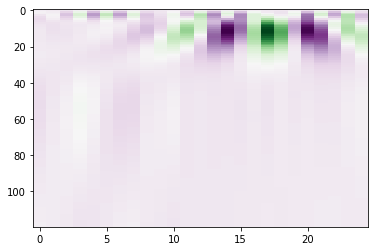

In [49]:
plt.imshow(cwtmatr.reshape((-1, 4)).mean(axis=1).reshape((cwtmatr.shape[0], -1)), cmap='PRGn', aspect='auto')
plt.show()

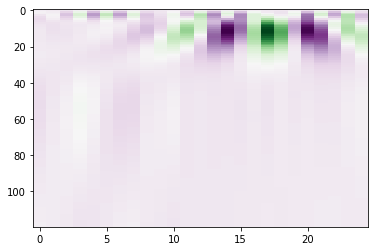

In [50]:
plt.imshow(cwtmatr.reshape((-1, 8)).mean(axis=1).reshape((cwtmatr.shape[0], -1)), cmap='PRGn', aspect='auto')
plt.show()

In [71]:
max_idx = np.abs(cwtmatr).reshape((-1, 4)).argmax(axis=1)

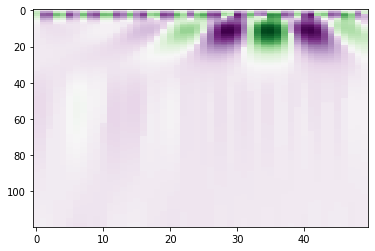

In [82]:
cwtmatr_absmax = cwtmatr.reshape((-1, 4))
cwtmatr_absmax = np.array([max(cwtmatr_absmax[i], key=abs) for i in range(cwtmatr_absmax.shape[0])]).reshape((cwtmatr.shape[0], -1))
plt.imshow(cwtmatr_absmax, cmap='PRGn', aspect='auto')
plt.show()

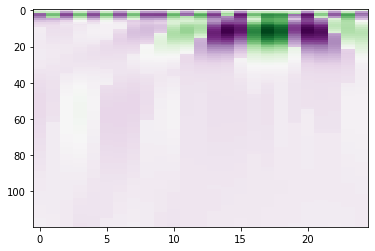

In [83]:
cwtmatr_absmax = cwtmatr.reshape((-1, 8))
cwtmatr_absmax = np.array([max(cwtmatr_absmax[i], key=abs) for i in range(cwtmatr_absmax.shape[0])]).reshape((cwtmatr.shape[0], -1))
plt.imshow(cwtmatr_absmax, cmap='PRGn', aspect='auto')
plt.show()

In [ ]:
cwtmatr_mean = cwtmatr
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

In [18]:
!pip install seaborn

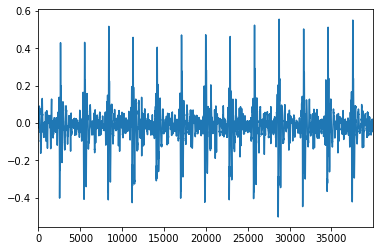

In [19]:
pd.Series(wave).plot()

In [20]:
wave

array([-0.02627563, -0.02386475, -0.01989746, ..., -0.01312256,
       -0.01193237, -0.01351929], dtype=float32)

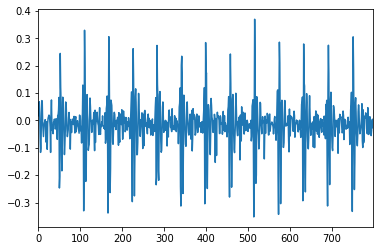

In [21]:
pd.Series(wave.reshape((-1, 50)).mean(axis=1)).plot()

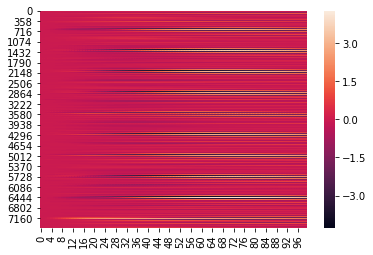

In [22]:
sns.heatmap(cwt(wave[:30000].reshape((1, -1)), np.arange(1, 101))[0].numpy())

In [23]:
cwt(wave[:30000].reshape((1, -1)), np.arange(1, 101))[0].numpy()

array([[-0.00704342, -0.02058078, -0.03243198, ...,  0.17487812,
         0.18755636,  0.20019674],
       [-0.00124743, -0.00751927, -0.02030472, ...,  0.21228048,
         0.2250598 ,  0.23777059],
       [ 0.00222426,  0.00994569,  0.01853462, ...,  0.250889  ,
         0.26370385,  0.27641946],
       ...,
       [-0.00068209, -0.00227571, -0.00151138, ..., -0.00037635,
        -0.00771052, -0.01480787],
       [ 0.00117295,  0.00525222,  0.018505  , ...,  0.03702259,
         0.02924108,  0.02169201],
       [ 0.008057  ,  0.02225973,  0.02979018, ...,  0.07297914,
         0.06483591,  0.056917  ]], dtype=float32)

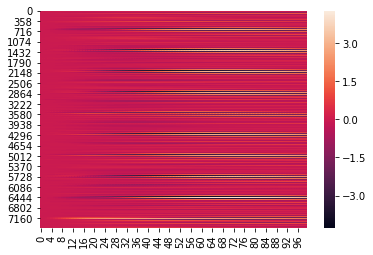

In [24]:
sns.heatmap(cwt(wave[:30000].reshape((1, -1)), np.arange(1, 101))[0])

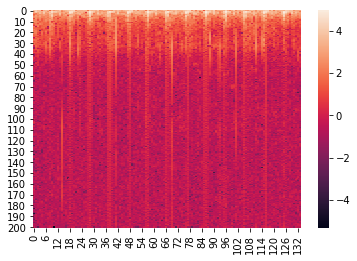

In [25]:
y = to_spect(wave[:60000].reshape((1, -1)), sr=4000, window_size=0.1, window_stride=0.075, window='hamming')[0]
y = (y - y.mean()).div(y.std()).transpose(0, 1)
sns.heatmap(y.numpy())

## Log-Mel spectrogram

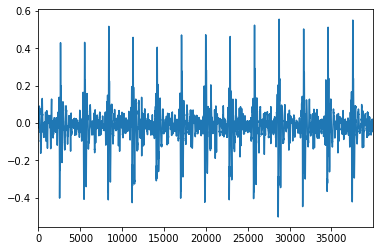

In [26]:
pd.Series(wave).plot()

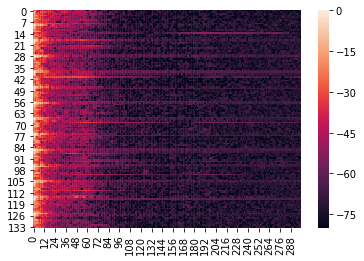

In [27]:
import librosa
y = logmel(wave[:60000].reshape((1, -1)), sr=4000, window_size=0.1, window_stride=0.075, window='hamming')[0]
# y = (y - y.mean()).div(y.std()).transpose(0, 1)
sns.heatmap(y.numpy())

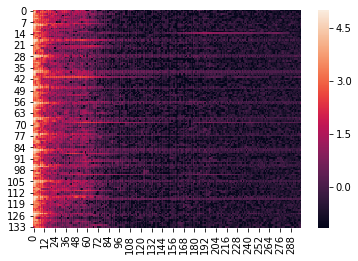

In [28]:
import librosa
y = logmel(wave[:60000].reshape((1, -1)), sr=4000, window_size=0.1, window_stride=0.075, window='hamming')[0]
y = (y - y.mean()).div(y.std())
sns.heatmap(y.numpy())

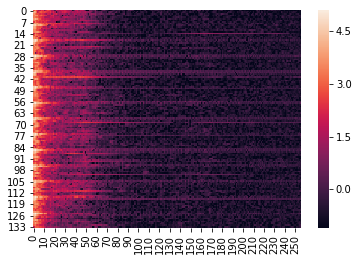

In [29]:
n_mels = 256
y = logmel(wave[:60000].reshape((1, -1)), sr=4000, window_size=0.1, window_stride=0.075, window='hamming', n_mels=n_mels)[0]
y = (y - y.mean()).div(y.std())
sns.heatmap(y.numpy())

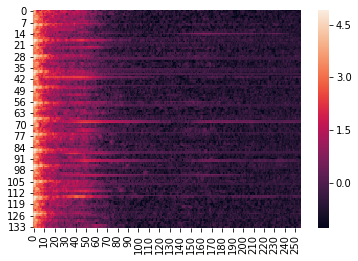

In [30]:
n_mels = 256
y = logmel(wave[:60000].reshape((1, -1)), sr=4000, window_size=0.2, window_stride=0.075, window='hamming', n_mels=n_mels)[0]
y = (y - y.mean()).div(y.std())
sns.heatmap(y.numpy())

In [31]:
wave.shape

(40000,)

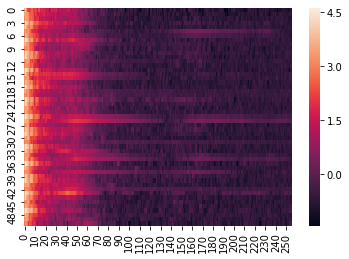

In [32]:
n_mels = 256
y = logmel(wave.reshape((1, -1)), sr=4000, window_size=0.5, window_stride=0.2, window='hamming', n_mels=n_mels)[0]
y = (y - y.mean()).div(y.std())
sns.heatmap(y.numpy())

In [33]:
train = pd.read_csv(DATA_DIR / 'train_manifest.csv', header=None)
wave_30, _ = load(train.iloc[0, 0], sr=4000)

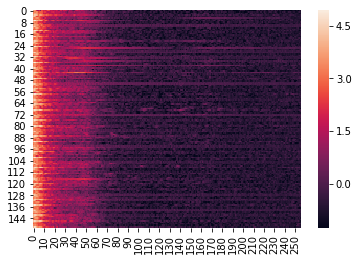

In [34]:
n_mels = 256
y = logmel(wave_30.reshape((1, -1)), sr=4000, window_size=0.2, window_stride=0.2, window='hamming', n_mels=n_mels)[0]
y = (y - y.mean()).div(y.std())
sns.heatmap(y.numpy())

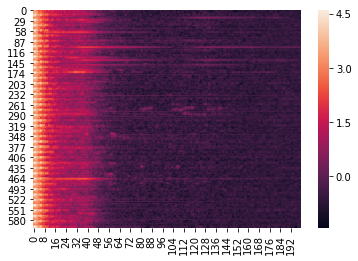

In [35]:
n_mels = 200
y = logmel(wave_30.reshape((1, -1)), sr=4000, window_size=0.5, window_stride=0.05, window='hamming', n_mels=n_mels)[0]
y = (y - y.mean()).div(y.std())
sns.heatmap(y.numpy())

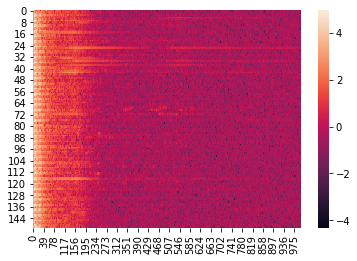

In [36]:
y = to_spect(wave_30.reshape((1, -1)), sr=4000, window_size=0.5, window_stride=0.2, window='hamming')[0]
y = (y - y.mean()).div(y.std())
sns.heatmap(y.numpy())